## 介紹
- BST推薦系統重點在於改善過往推薦系統沒有考慮序列歷史資訊，透過Transoformer 的 Encoder結構將其引入，使得推薦系統加入了此項考量，改善推薦系統效果。
- 論文對比的對象是WDL以及DIN，DIN需要再研究一下才能夠比較完整差別。
- 因為此問題是rating，而論文中是CTR也就是二元分類的機率，故有所不同。
- 同上，其中特徵的處理也有些許差異，如target item id因為沒有rating, 故本來使用positional embedding會是完整長度, 變為length-1；且改用element-wise product取代concatenate。

---

- 輸入
    - other features: 如age, user profile...
    - sequence data:
        - sequence rating
        - sequence item id
- 輸出
    - rating(0~5)

## 專案框架
- 準備資料
    - movielens 1M
- 資料前處理
    - 將movielens dataset轉換成seq data
    - 將dataset切分成train, test
- 模型建構
- 訓練以及測試

In [73]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
import matplotlib.pyplot as plt

### 準備資料

In [3]:
# 下載並將其轉換成df

# 下載zip檔案
urlretrieve(url="http://files.grouplens.org/datasets/movielens/ml-1m.zip", filename='movielens.zip')

# 解壓縮
ZipFile(file='movielens.zip', mode='r').extractall()

In [5]:
!dir

 磁碟區 C 中的磁碟是 Local Disk
 磁碟區序號:  A293-6294

 C:\Users\aband\OneDrive\桌面\推薦系統\BST 的目錄

2021/09/24  下午 09:19    <DIR>          .
2021/09/24  下午 09:19    <DIR>          ..
2021/09/24  下午 07:57    <DIR>          .ipynb_checkpoints
2021/09/24  下午 09:19             2,916 Behavior Sequence Transformer(BST) 推薦系統.ipynb
2021/05/14  上午 06:28         2,431,638 BST.pdf
2021/09/24  下午 08:43           200,298 BST模型實作.ipynb
2021/05/13  下午 10:25    <DIR>          ml-1m
2021/09/24  下午 09:19         5,917,549 movielens.zip
2021/05/14  上午 11:02         7,248,663 test_data.csv
2021/05/14  上午 11:02        41,156,343 train_data.csv
               6 個檔案      56,957,407 位元組
               4 個目錄  19,945,353,216 位元組可用


In [17]:
# 透過pd.read_csv讀取檔案 .dat檔案

users = pd.read_csv(
    'ml-1m/users.dat',sep='::', names=['user_id', 'sex', 'age_group', 'occupation', 'zip_code']
)
ratings = pd.read_csv(
    'ml-1m/ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'unix_timestamp']
)
movies = pd.read_csv(
    'ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres']
)

C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.
C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys
C:\Users\aband\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by

In [18]:
users.head()

,user_id,sex,age_group,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [19]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [20]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
users.info()
ratings.info()
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   sex         6040 non-null   object
 2   age_group   6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   user_id         1000209 non-null  int64
 1   movie_id        1000209 non-null  int64
 2   rating          1000209 non-null  int64
 3   unix_timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtyp

In [22]:
# 將資料型態轉換

users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [23]:
# 每一部電影可能屬於多種的電影類型，透過pd去處理，轉換成multi-hot

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

for genre in genres:
    movies[genre] = movies['genres'].apply(lambda values: int(genre in values.split('|')))

In [24]:
movies.head()

,movie_id,title,genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,movie_1,Toy Story (1995),Animation|Children's|Comedy,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,movie_2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,movie_3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,movie_4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,movie_5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 將資料轉換成序列資料
- 透過時間排序
- 透過user id 打包成group
- 透過固定長度切分資料, step_size可以自己控制。

In [26]:
ratings_group = ratings.sort_values(by=['unix_timestamp']).groupby('user_id')
ratings_group.groups

{'user_1': [31, 27, 22, 37, 24, 36, 3, 47, 7, 44, 21, 0, 9, 51, 43, 41, 48, 18, 11, 14, 42, 45, 17, 39, 26, 2, 6, 19, 52, 38, 1, 13, 49, 50, 15, 46, 20, 5, 8, 12, 28, 23, 29, 10, 33, 40, 16, 35, 30, 4, 34, 32, 25], 'user_10': [869, 998, 880, 1116, 943, 947, 1115, 900, 1154, 1040, 1173, 1045, 1157, 1056, 1035, 844, 1095, 890, 1168, 800, 1143, 968, 1160, 970, 1091, 1127, 1000, 966, 888, 1125, 859, 1176, 924, 913, 935, 956, 931, 874, 973, 946, 1169, 1119, 1129, 1120, 1151, 1086, 1135, 834, 829, 957, 882, 1050, 1026, 993, 863, 937, 814, 921, 821, 1005, 833, 990, 831, 984, 1124, 1014, 1094, 1074, 1164, 994, 939, 815, 1088, 872, 982, 835, 804, 1081, 1162, 875, 802, 1136, 1065, 849, 1053, 1049, 837, 855, 1048, 1046, 885, 1177, 809, 1155, 1029, 884, 1167, 915, 959, 942, ...], 'user_100': [12950, 12940, 12906, 12970, 12967, 12902, 12948, 12943, 12901, 12904, 12920, 12971, 12925, 12974, 12972, 12911, 12946, 12919, 12964, 12934, 12929, 12905, 12954, 12973, 12953, 12956, 12955, 12903, 12907, 12922

In [36]:
# 當group by 之後, movie_id就變成像是column的存在
list(ratings_group.movie_id.apply(list))[0]

['movie_3186',
 'movie_1721',
 'movie_1270',
 'movie_1022',
 'movie_2340',
 'movie_1836',
 'movie_3408',
 'movie_1207',
 'movie_2804',
 'movie_260',
 'movie_720',
 'movie_1193',
 'movie_919',
 'movie_608',
 'movie_2692',
 'movie_1961',
 'movie_2028',
 'movie_3105',
 'movie_938',
 'movie_1035',
 'movie_1962',
 'movie_1028',
 'movie_2018',
 'movie_150',
 'movie_1097',
 'movie_914',
 'movie_1287',
 'movie_2797',
 'movie_1246',
 'movie_2762',
 'movie_661',
 'movie_2918',
 'movie_531',
 'movie_3114',
 'movie_2791',
 'movie_1029',
 'movie_2321',
 'movie_1197',
 'movie_594',
 'movie_2398',
 'movie_1545',
 'movie_527',
 'movie_745',
 'movie_595',
 'movie_588',
 'movie_1',
 'movie_2687',
 'movie_783',
 'movie_2294',
 'movie_2355',
 'movie_1907',
 'movie_1566',
 'movie_48']

In [38]:
# 轉換成df, 其column 為list

ratings_data = pd.DataFrame(
    data={
        'user_id': list(ratings_group.groups.keys()),
        'movie_ids': list(ratings_group.movie_id.apply(list)),
        'ratings': list(ratings_group.rating.apply(list)),
        'timestamps': list(ratings_group.unix_timestamp.apply(list))
    }
)
ratings_data.head()

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."
3,user_1000,"[movie_971, movie_260, movie_2990, movie_2973,...","[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...","[975040566, 975040566, 975040566, 975040629, 9..."
4,user_1001,"[movie_1198, movie_1617, movie_2885, movie_390...","[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0, ...","[975039591, 975039702, 975039702, 975039898, 9..."


In [39]:
# 透過固定長度切分資料

seq_length = 4
step_size = 2

def create_seq(values, window_size=seq_length, step_size=step_size):
    seqs = []
    start_idx = 0
    while True:
        end_idx = start_idx + window_size
        seq = values[start_idx:end_idx]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                seqs.append(seq)
            break
        seqs.append(seq)
        start_idx += step_size
    return seqs

ratings_data['movie_ids'] = ratings_data['movie_ids'].apply(
    lambda values: create_seq(values)
)
ratings_data['ratings'] = ratings_data['ratings'].apply(
    lambda values: create_seq(values)
)

del ratings_data['timestamps']

In [41]:
ratings_data.head()

,user_id,movie_ids,ratings
0,user_1,"[[movie_3186, movie_1721, movie_1270, movie_10...","[[4.0, 4.0, 5.0, 5.0], [5.0, 5.0, 3.0, 5.0], [..."
1,user_10,"[[movie_597, movie_858, movie_743, movie_1210]...","[[4.0, 3.0, 3.0, 4.0], [3.0, 4.0, 4.0, 5.0], [..."
2,user_100,"[[movie_260, movie_1676, movie_1198, movie_541...","[[4.0, 3.0, 4.0, 3.0], [4.0, 3.0, 4.0, 3.0], [..."
3,user_1000,"[[movie_971, movie_260, movie_2990, movie_2973...","[[4.0, 5.0, 4.0, 3.0], [4.0, 3.0, 5.0, 5.0], [..."
4,user_1001,"[[movie_1198, movie_1617, movie_2885, movie_39...","[[4.0, 4.0, 4.0, 2.0], [4.0, 2.0, 2.0, 1.0], [..."


> 但數面的data是不能夠用於訓練的，將其轉換為一row為一筆輸入更為合適

In [55]:
# 透過df.explode擴展
ratings_data_movies = ratings_data[['user_id', 'movie_ids']].explode(column='movie_ids', ignore_index=True)
ratings_data_ratings = ratings_data[['ratings']].explode(column='ratings', ignore_index=True)

# 上面的資訊還需要透過concate, 去將其整合
ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_ratings], axis=1)
# ratings_data_transformed

# 將users info concate上去
ratings_data_transformed = ratings_data_transformed.join(users.set_index('user_id'), on='user_id')
# ratings_data_transformed

# movie_ids, ratings都是list of data, 需要去轉換成str, 供後續方便轉換
ratings_data_transformed['movie_ids'] = ratings_data_transformed['movie_ids'].apply(lambda x: ','.join(x))
ratings_data_transformed['ratings'] = ratings_data_transformed['ratings'].apply(lambda x: ','.join(list(map(str, x))))

# 刪除不必要的column
del ratings_data_transformed['zip_code']

# rename column name
ratings_data_transformed.rename(columns={'movie_ids': 'seq_movie_ids', 'ratings': 'seq_ratings'}, inplace=True)
ratings_data_transformed

,user_id,seq_movie_ids,seq_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10
...,...,...,...,...,...,...
498618,user_999,"movie_2676,movie_2540,movie_1363,movie_765","3.0,2.0,3.0,3.0",M,group_25,occupation_15
498619,user_999,"movie_1363,movie_765,movie_3565,movie_1410","3.0,3.0,4.0,2.0",M,group_25,occupation_15
498620,user_999,"movie_3565,movie_1410,movie_2269,movie_2504","4.0,2.0,3.0,3.0",M,group_25,occupation_15
498621,user_999,"movie_2269,movie_2504,movie_455,movie_193","3.0,3.0,2.0,2.0",M,group_25,occupation_15


In [61]:
# 資料至上面基本上處理完畢, 現在將其切分成train/test: 85:15, 且將其儲存再csv, 就不用每一次都要重新處理

random_selection = np.random.rand(len(ratings_data_transformed) ) <= 0.85
print(random_selection.shape)
train_data = ratings_data_transformed[random_selection]
test_data = ratings_data_transformed[~random_selection]

# 一些超參數可以看習慣設定, 目前這樣是最精簡的模式
train_data.to_csv('train_data.csv', index=False, sep='|', header=False)
test_data.to_csv('test_data.csv', index=False, sep='|', header=False)


print(train_data.shape)
print(test_data.shape)
train_data.head()

(498623,)
(424109, 6)
(74514, 6)


,user_id,seq_movie_ids,seq_ratings,sex,age_group,occupation
0,user_1,"movie_3186,movie_1721,movie_1270,movie_1022","4.0,4.0,5.0,5.0",F,group_1,occupation_10
1,user_1,"movie_1270,movie_1022,movie_2340,movie_1836","5.0,5.0,3.0,5.0",F,group_1,occupation_10
2,user_1,"movie_2340,movie_1836,movie_3408,movie_1207","3.0,5.0,4.0,4.0",F,group_1,occupation_10
3,user_1,"movie_3408,movie_1207,movie_2804,movie_260","4.0,4.0,5.0,4.0",F,group_1,occupation_10
4,user_1,"movie_2804,movie_260,movie_720,movie_1193","5.0,4.0,3.0,5.0",F,group_1,occupation_10


### 定義一些metadata供後續使用

In [58]:
CSV_HEADER = list(ratings_data_transformed.columns)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(users.user_id.unique()),
    "movie_id": list(movies.movie_id.unique()),
    "sex": list(users.sex.unique()),
    "age_group": list(users.age_group.unique()),
    "occupation": list(users.occupation.unique()),
}

USER_FEATURES = ["sex", "age_group", "occupation"]

MOVIE_FEATURES = ["genres"]

### 創造tf.data.Dataset

In [59]:
def get_ds_from_csv(csv_file_path, shuffle=False, batch_size=256):
    def process(features):
        movie_ids_string = features["seq_movie_ids"]
        sequence_movie_ids = tf.strings.split(movie_ids_string, ",").to_tensor()

        # The last movie id in the sequence is the target movie.
        features["target_movie_id"] = sequence_movie_ids[:, -1]
        features["seq_movie_ids"] = sequence_movie_ids[:, :-1]

        ratings_string = features["seq_ratings"]
        sequence_ratings = tf.strings.to_number(
            tf.strings.split(ratings_string, ","), tf.dtypes.float32
        ).to_tensor()

        # The last rating in the sequence is the target for the model to predict.
        target = sequence_ratings[:, -1]
        features["seq_ratings"] = sequence_ratings[:, :-1]

        return features, target

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    ).map(process)

    return dataset

In [67]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "seq_movie_ids": layers.Input(
            name="seq_movie_ids", shape=(seq_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "seq_ratings": layers.Input(
            name="seq_ratings", shape=(seq_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

## Encode input features
### The encode_input_features method works as follows:

1. Each categorical user feature is encoded using layers.Embedding, with embedding dimension equals to the square root of the vocabulary size of the feature. The embeddings of these features are concatenated to form a single input tensor.

2. Each movie in the movie sequence and the target movie is encoded layers.Embedding, where the dimension size is the square root of the number of movies.

3. A multi-hot genres vector for each movie is concatenated with its embedding vector, and processed using a non-linear layers.Dense to output a vector of the same movie embedding dimensions.

4. A positional embedding is added to each movie embedding in the sequence, and then multiplied by its rating from the ratings sequence.

5. The target movie embedding is concatenated to the sequence movie embeddings, producing a tensor with the shape of [batch size, sequence length, embedding size], as expected by the attention layer for the transformer architecture.

6. The method returns a tuple of two elements: encoded_transformer_features and encoded_other_features.

In [78]:
# tf.unstack 拆解範例

x = tf.reshape(tf.range(12), (3, 4))
print(x)

# axis=0, 沿著axis=0, 將向量拆解
print(tf.unstack(x))  # 拆解成3*(4,)

print()
# axis=1, 沿著axis=1, 將向量拆解
print(tf.unstack(x, axis=1))  # 解決成4*(3,)

tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]], shape=(3, 4), dtype=int32)
[<tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 1, 2, 3])>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 5, 6, 7])>, <tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 8,  9, 10, 11])>]

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 4, 8])>, <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 5, 9])>, <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 2,  6, 10])>, <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 3,  7, 11])>]


In [85]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):
    """
        將輸入特徵進入embedding進行轉換，可以參考論文架構!
        1. 先將other_feature embedding
        2. 將movie(id, other movie feature) embedding
        3. 
    """
    # 詳可見論文
    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features, 根據論文, 每一個特徵都會去embedding!
    for feature_name in other_feature_names:
        # 將字串轉換成index, 之後embedding的輸入
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions, 這邊是用vocab的平方根當做embedding_dim, 但不一定要, 可以經由超參數調整
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions. 將離散特徵投射到稠密向量, 經由訓練學習參數
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()  # 每一部電影屬於哪幾個種類
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],  # 可以考慮一下換別的, 這裡可能會混淆
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,   # why?
        name="genres_vector",
    )
    # Create a processing layer for genres.(因為上面的movie_genres_lookup只能充當lookup(trainable=False), 故透過Dense學習)
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id. 透過 movie_id、電影種類去做Dense運算
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    ## 此處跟論文有所不同, 論文的position與movie seq embedding是透過concatenate然後去丟入MLP
    ## 但可能是因為這篇是rating, 因此, target movie id是沒有對應的rating vector的, 故才使用element-wise product, 然後target movie id另外再concatenate上去
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["seq_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding. 這邊用embedding直接學習, 論文中是採用固定的運算方式
    position_embedding_encoder = layers.Embedding(
        input_dim=seq_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=seq_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    # inputs['sequence_ratings']此時會return 一個list
    sequence_ratings = tf.expand_dims(inputs["seq_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )    # element-wise multiply ---> 
    
    # Construct the transformer inputs. ---> 將tensor沿著axis拆掉, 如(batch_size, 3,  62) axis=1 ---> 變成 3*(batch_size, 62)
#     for encoded_movie in tf.unstack(
#         encoded_sequence_movies_with_poistion_and_rating, axis=1
#     ):
#         encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))  # (batch_size, 1, 62)
#     encoded_transformer_features.append(encoded_target_movie)

#     encoded_transformer_features = layers.concatenate(
#         encoded_transformer_features, axis=1
#     )  # (batch_size, ?, 62)
    # 看起來上面先unstack完全可以不做呀 ---> 是的, 檢查過且模型效果相同
    encoded_transformer_features.append(encoded_sequence_movies_with_poistion_and_rating)
    encoded_transformer_features.append(encoded_target_movie)
    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )
    
    return encoded_transformer_features, encoded_other_features

In [86]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3


def create_model(
    include_user_id=False, 
    include_user_features=False, 
    include_movie_features=False, 
    hidden_units=[256, 128],
    dropout_rate=0.1,
    num_heads=3
):
    inputs = create_model_inputs()
    transformer_features, other_features = encode_input_features(
        inputs, include_user_id, include_user_features, include_movie_features
    )
    

    # Create a multi-headed attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=transformer_features.shape[2], dropout=dropout_rate
    )(transformer_features, transformer_features)

    # Transformer block. 根據論文實測效果 b=1 是效果/效率都不錯的結果。
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x1 = layers.Add()([transformer_features, attention_output])    # Transformer的short-cut
    x1 = layers.LayerNormalization()(x1)
    x2 = layers.LeakyReLU()(x1)
    x2 = layers.Dense(units=x2.shape[-1])(x2)
    x2 = layers.Dropout(dropout_rate)(x2)
    transformer_features = layers.Add()([x1, x2])                  # short-cut
    transformer_features = layers.LayerNormalization()(transformer_features)
    features = layers.Flatten()(transformer_features)              # 最後要打平才能進入預測

    # Included the other features.
    if other_features is not None:
        features = layers.concatenate(
            [features, layers.Reshape([other_features.shape[-1]])(other_features)]
        )
        print(transformer_features.shape, other_features.shape)

    # Fully-connected layers.
    for num_units in hidden_units:
        features = layers.Dense(num_units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.LeakyReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_movie_ids (InputLayer)      [(None, 3)]          0                                            
__________________________________________________________________________________________________
movie_index_lookup (StringLooku multiple             0           target_movie_id[0][0]            
                                                                 seq_movie_ids[0][0]              
__________________________________________________________________________________________________
movie_embedding (Embedding)     multiple             240746      movie_index_lookup[0][0]         
                                                                 movie_index_lookup[1][0]         
____________________________________________________________________________________________

In [87]:
# Compile the model.
model.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()],
)

# Read the training data.
train_dataset = get_ds_from_csv("train_data.csv", shuffle=True, batch_size=256)

# Read the test data.
test_dataset = get_ds_from_csv("test_data.csv", batch_size=256)

# Fit the model with the training data.
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)


# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)   # Returns the loss value & metrics values for the model in test mode.
print(f"Test MAE: {round(rmse, 3)}")

Epoch 1/5
1657/1657 [==============================] - 67s 38ms/step - loss: 1.2638 - mean_absolute_error: 0.8915 - val_loss: 0.9536 - val_mean_absolute_error: 0.7797
Epoch 2/5
1657/1657 [==============================] - 38s 23ms/step - loss: 1.0188 - mean_absolute_error: 0.8049 - val_loss: 0.9402 - val_mean_absolute_error: 0.7809
Epoch 3/5
1657/1657 [==============================] - 51s 31ms/step - loss: 0.9623 - mean_absolute_error: 0.7816 - val_loss: 0.9318 - val_mean_absolute_error: 0.7761: 0s - loss: 0.9626 - mean_absolute_error:
Epoch 4/5
1657/1657 [==============================] - 74s 45ms/step - loss: 0.9284 - mean_absolute_error: 0.7677 - val_loss: 0.9117 - val_mean_absolute_error: 0.7638
Epoch 5/5
1657/1657 [==============================] - 57s 34ms/step - loss: 0.9098 - mean_absolute_error: 0.7593 - val_loss: 0.9140 - val_mean_absolute_error: 0.7666
Test MAE: 0.767


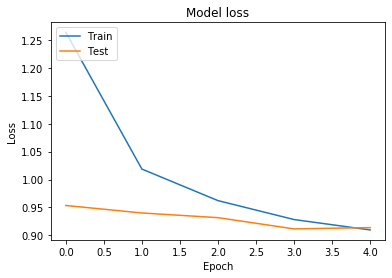

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 嘗試其他設定
- incluser user_id, user features, movie_features
    - 結果是更好的!

In [75]:
# 最完整的使用特徵

include_user_id = True
include_user_features = True
include_movie_features = True

hidden_units = [256, 128]
dropout_rate = 0.1
num_heads = 3

bst = create_model(include_user_id, include_user_features, include_movie_features)
bst.summary()

(None, 4, 62) (None, 1, 84)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_movie_ids (InputLayer)      [(None, 3)]          0                                            
__________________________________________________________________________________________________
movie_index_lookup (StringLooku multiple             0           target_movie_id[0][0]            
                                                                 seq_movie_ids[0][0]              
__________________________________________________________________________________________________
movie_embedding (Embedding)     multiple             240746      movie_index_lookup[0][0]         
                                                                 movie_index_lookup[1][0]         
________________________________________________________________

In [79]:
# 設定與訓練

bst.compile(
    optimizer=keras.optimizers.Adagrad(learning_rate=0.01),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.losses.MeanAbsoluteError()],
)

bst_history = bst.fit(train_dataset, epochs=5, validation_data=test_dataset)

print(bst.evaluate(test_dataset))

Epoch 1/5
1657/1657 [==============================] - 79s 45ms/step - loss: 1.2945 - mean_absolute_error: 0.9004 - val_loss: 0.9948 - val_mean_absolute_error: 0.8085
Epoch 2/5
1657/1657 [==============================] - 68s 41ms/step - loss: 1.0639 - mean_absolute_error: 0.8236 - val_loss: 0.9428 - val_mean_absolute_error: 0.7848
Epoch 3/5
1657/1657 [==============================] - 72s 43ms/step - loss: 0.9959 - mean_absolute_error: 0.7953 - val_loss: 0.8962 - val_mean_absolute_error: 0.7558
Epoch 4/5
1657/1657 [==============================] - 67s 40ms/step - loss: 0.9631 - mean_absolute_error: 0.7814 - val_loss: 0.8827 - val_mean_absolute_error: 0.7491
Epoch 5/5
292/292 [==============================] - 4s 12ms/step - loss: 0.8875 - mean_absolute_error: 0.7537
[0.8875350952148438, 0.7537391781806946]


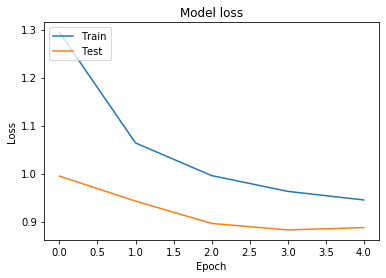

In [80]:
plt.plot(bst_history.history['loss'])
plt.plot(bst_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()